In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

prefix = 'serverless_v3_raw_data/'
filename = f"{prefix}/logs.csv"
logs = pd.read_csv(filename, parse_dates=['timestamp'], index_col='timestamp').sort_values(by='timestamp')

logs


,duration,billedDuration,maxMemoryUsed,memorySize
timestamp,,,,
2022-12-22 07:37:34.564,8931.67,8932.0,335000000.0,1.024000e+09
2022-12-22 07:38:49.807,251.10,252.0,339000000.0,1.024000e+09
2022-12-22 07:39:00.472,54.31,55.0,339000000.0,1.024000e+09
2022-12-22 07:39:15.172,74.30,75.0,339000000.0,1.024000e+09
2022-12-22 07:39:28.349,11.82,12.0,339000000.0,1.024000e+09
...,...,...,...,...
2022-12-22 12:56:02.449,368.61,369.0,336000000.0,1.024000e+09
2022-12-22 12:56:04.268,8605.94,8606.0,333000000.0,1.024000e+09
2022-12-22 12:56:04.971,39.23,40.0,333000000.0,1.024000e+09


In [3]:
# Number of coldstarts across the whole load
logs[logs.billedDuration > 3000].count()

duration          33
billedDuration    33
maxMemoryUsed     33
memorySize        33
dtype: int64

In [4]:
invocations = pd.read_csv(f"{prefix}/invocations.csv", parse_dates=['timestamp'], index_col='timestamp').sort_values(by='timestamp')
invocations

,invocations
timestamp,
2022-12-22 07:37:00,1
2022-12-22 07:38:00,1
2022-12-22 07:39:00,5
2022-12-22 07:40:00,8
2022-12-22 07:41:00,16
...,...
2022-12-22 12:52:00,49
2022-12-22 12:53:00,48
2022-12-22 12:54:00,42


In [5]:
concurrent = pd.read_csv(f"{prefix}/concurrent-executions.csv", parse_dates=['timestamp'], index_col='timestamp').sort_values(by='timestamp')
concurrent


,concurrentExecutions
timestamp,
2022-12-22 07:37:00,1
2022-12-22 07:38:00,1
2022-12-22 07:39:00,5
2022-12-22 07:40:00,8
2022-12-22 07:41:00,31
...,...
2022-12-22 12:52:00,59
2022-12-22 12:53:00,48
2022-12-22 12:54:00,43


In [6]:
cold_starts = logs[logs['billedDuration'] > 5000].resample('10T').count()

resampled_concurrent = concurrent.resample('10T').sum()
resampled_invocations = invocations.resample('10T').sum()


/tmp/ipykernel_43225/2809307341.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


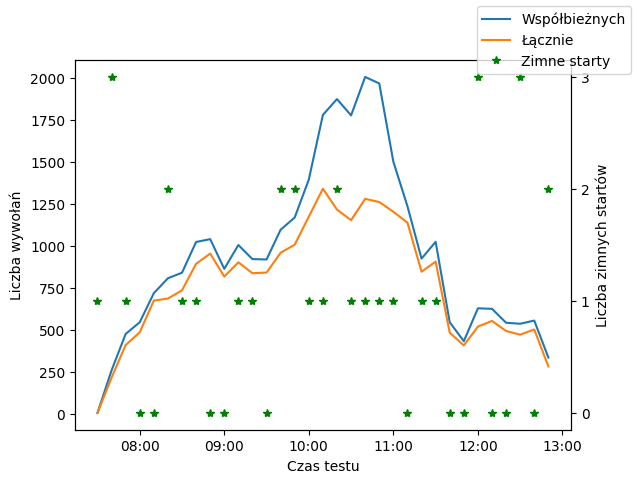

In [7]:
fig, ax = plt.subplots()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.plot(resampled_concurrent.index, resampled_concurrent['concurrentExecutions'], label="Współbieżnych")
ax.plot(resampled_invocations.index, resampled_invocations['invocations'], label="Łącznie")
ax.set_ylabel("Liczba wywołań")
ax.set_xlabel("Czas testu")

ax2 = ax.twinx()
ax2.plot(cold_starts.index, cold_starts['duration'], color='green', marker='*', linestyle='None', label='Zimne starty')
ax2.set_ylabel("Liczba zimnych startów")
ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer = True))

fig.legend()
fig.show()

# TODO: why there is more concurrent than total?

/tmp/ipykernel_43225/3278083452.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


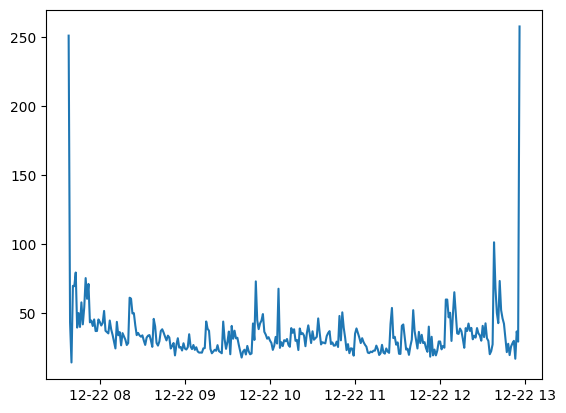

In [15]:
fig, ax = plt.subplots()

logs_resampled = logs[logs.duration < 5000].resample('1T').mean()

# logs_resampled
ax.plot(logs_resampled.index, logs_resampled['duration'])

fig.show()